In [1]:
import pandas as pd
import numpy as np

# Load dataset — escape backslashes properly or use raw string
data = pd.read_csv(r"eVED\eVED_171101_week.csv")

# View first few rows
print(data.head())

     DayNum  VehId   Trip  Timestamp(ms)  Latitude[deg]  Longitude[deg]  \
0  1.586651    8.0  706.0            0.0      42.277558       -83.69875   
1  1.586651    8.0  706.0          200.0      42.277558       -83.69875   
2  1.586651    8.0  706.0         1100.0      42.277558       -83.69875   
3  1.586651    8.0  706.0         2100.0      42.277558       -83.69875   
4  1.586651    8.0  706.0         4200.0      42.277558       -83.69875   

   Vehicle Speed[km/h]  MAF[g/sec]  Engine RPM[RPM]  Absolute Load[%]  ...  \
0                 40.0   22.129999           2285.0         49.019608  ...   
1                 40.0   22.129999           2285.0         67.450981  ...   
2                 45.0   22.129999           2285.0         67.450981  ...   
3                 47.0    6.150000           2744.0         67.450981  ...   
4                 48.0   21.440001           1982.0         67.450981  ...   

   Energy_Consumption  Matchted Latitude[deg]  Matched Longitude[deg]  \
0      

C:\Users\dines\AppData\Local\Temp\ipykernel_12540\86880616.py:5: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"eVED\eVED_171101_week.csv")


In [2]:
print(data.columns)

Index(['DayNum', 'VehId', 'Trip', 'Timestamp(ms)', 'Latitude[deg]',
       'Longitude[deg]', 'Vehicle Speed[km/h]', 'MAF[g/sec]',
       'Engine RPM[RPM]', 'Absolute Load[%]', 'OAT[DegC]', 'Fuel Rate[L/hr]',
       'Air Conditioning Power[kW]', 'Air Conditioning Power[Watts]',
       'Heater Power[Watts]', 'HV Battery Current[A]', 'HV Battery SOC[%]',
       'HV Battery Voltage[V]', 'Short Term Fuel Trim Bank 1[%]',
       'Short Term Fuel Trim Bank 2[%]', 'Long Term Fuel Trim Bank 1[%]',
       'Long Term Fuel Trim Bank 2[%]', 'Elevation Raw[m]',
       'Elevation Smoothed[m]', 'Gradient', 'Energy_Consumption',
       'Matchted Latitude[deg]', 'Matched Longitude[deg]', 'Match Type',
       'Class of Speed Limit', 'Speed Limit[km/h]',
       'Speed Limit with Direction[km/h]', 'Intersection', 'Bus Stops',
       'Focus Points'],
      dtype='object')


In [3]:
# Convert speed from km/h to mph
data['speed_mph'] = data['Vehicle Speed[km/h]'] * 0.621371

# Rename columns to match RouteE expected names
data.rename(columns={
    'Gradient': 'grade_dec',
    'Class of Speed Limit': 'road_class',
    'OAT[DegC]': 'ambient_temp',
    'Energy_Consumption': 'energy_kWh_mi'
}, inplace=True)

# Steady temperature fill
data['ambient_temp'] = data['ambient_temp'].fillna(20)  # 20°C steady

# Simulate temperature varying between 15°C and 25°C across the dataset
data['ambient_temp_varying'] = 15 + 10 * np.sin(np.linspace(0, 2*np.pi, len(data)))

data['energy_kWh_mi'] = data['energy_kWh_mi'].fillna(2.0)  # placeholder


# Optional: preview processed data
print(data[['speed_mph','grade_dec','road_class','ambient_temp','energy_kWh_mi']].head())


   speed_mph  grade_dec  road_class  ambient_temp  energy_kWh_mi
0  24.854840   0.000000         0.0          20.0            2.0
1  24.854840   0.000000         0.0          20.0            2.0
2  27.961695   0.000000         0.0          20.0            2.0
3  29.204437   0.000000         0.0          20.0            2.0
4  29.825808   0.000415         0.0          20.0            2.0


In [4]:
from nrel.routee.powertrain import PowertrainType
print(list(PowertrainType))


[<PowertrainType.UNDEFINED: 0>, <PowertrainType.ICE: 1>, <PowertrainType.HEV: 2>, <PowertrainType.BEV: 3>, <PowertrainType.PHEV_EV_MODE: 4>, <PowertrainType.PHEV_HEV_MODE: 5>, <PowertrainType.HEAVY_DUTY: 6>]


In [ ]:
import nrel.routee.powertrain as pt
import pandas as pd
import numpy as np

# -----------------------
# Load dataset
# -----------------------
data = pd.read_csv(r"eVED\eVED_171101_week.csv")

# -----------------------
# Preprocess dataset
# -----------------------
data['speed_mph'] = data['Vehicle Speed[km/h]'] * 0.621371
data.rename(columns={
    'Gradient': 'grade_dec',
    'Class of Speed Limit': 'road_class',
    'OAT[DegC]': 'ambient_temp',
    'Energy_Consumption': 'energy_kWh_mi'
}, inplace=True)

# Fill missing values
data['ambient_temp'] = data['ambient_temp'].fillna(20)  # Steady temp placeholder
data['energy_kWh_mi'] = data['energy_kWh_mi'].fillna(2.0)  # Placeholder

# Create varying temperature column
data['ambient_temp_varying'] = 15 + 10 * np.sin(np.linspace(0, 2*np.pi, len(data)))

# -----------------------
# Load pre-trained BEV model
# -----------------------
model = pt.load_model('Transit_Bus_Battery_Electric')  # Or '2017_CHEVROLET_Bolt'

# Ensure Timestamp(ms) is numeric
data['Timestamp(ms)'] = pd.to_numeric(data['Timestamp(ms)'], errors='coerce')

# Compute time difference in hours
data['time_diff_hr'] = data['Timestamp(ms)'].diff() / (1000*3600)  # ms -> hours

# Fill first row with 0
data['time_diff_hr'].fillna(0, inplace=True)

# Compute distance in miles
data['miles'] = data['speed_mph'] * data['time_diff_hr']

# Optional: preview
print(data[['Timestamp(ms)', 'speed_mph', 'time_diff_hr', 'miles']].head())






# Rename dataset columns to match RouteE expected names
data.rename(columns={
    'speed_mph': 'gpsspeed',
    'grade_dec': 'grade',
    'road_class': 'road_class',       # Already same
    'ambient_temp': 'ambient_temp',
    'miles': 'miles'
}, inplace=True)

# Optional: check columns
print(data.columns)


# Steady temperature
data['pred_steady_kWh_mi'] = model.predict(data.assign(ambient_temp=data['ambient_temp']))

# Varying temperature
data['pred_varying_kWh_mi'] = model.predict(data.assign(ambient_temp=data['ambient_temp_varying']))

# Save predictions
data.to_csv('BEB_predictions.csv', index=False)

print(" Predictions complete! CSV saved as 'BEB_predictions.csv'")



C:\Users\dines\AppData\Local\Temp\ipykernel_12540\1627175819.py:8: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"eVED\eVED_171101_week.csv")
C:\Users\dines\AppData\Local\Temp\ipykernel_12540\1627175819.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['time_diff_hr'].fillna(0, inplace=True)


   Timestamp(ms)  speed_mph  time_diff_hr     miles
0            0.0  24.854840      0.000000  0.000000
1          200.0  24.854840      0.000056  0.001381
2         1100.0  27.961695      0.000250  0.006990
3         2100.0  29.204437      0.000278  0.008112
4         4200.0  29.825808      0.000583  0.017398
Index(['DayNum', 'VehId', 'Trip', 'Timestamp(ms)', 'Latitude[deg]',
       'Longitude[deg]', 'Vehicle Speed[km/h]', 'MAF[g/sec]',
       'Engine RPM[RPM]', 'Absolute Load[%]', 'ambient_temp',
       'Fuel Rate[L/hr]', 'Air Conditioning Power[kW]',
       'Air Conditioning Power[Watts]', 'Heater Power[Watts]',
       'HV Battery Current[A]', 'HV Battery SOC[%]', 'HV Battery Voltage[V]',
       'Short Term Fuel Trim Bank 1[%]', 'Short Term Fuel Trim Bank 2[%]',
       'Long Term Fuel Trim Bank 1[%]', 'Long Term Fuel Trim Bank 2[%]',
       'Elevation Raw[m]', 'Elevation Smoothed[m]', 'grade', 'energy_kWh_mi',
       'Matchted Latitude[deg]', 'Matched Longitude[deg]', 'Match Type',


C:\Users\dines\AppData\Local\Temp\ipykernel_12540\527832380.py:5: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('BEB_predictions.csv')


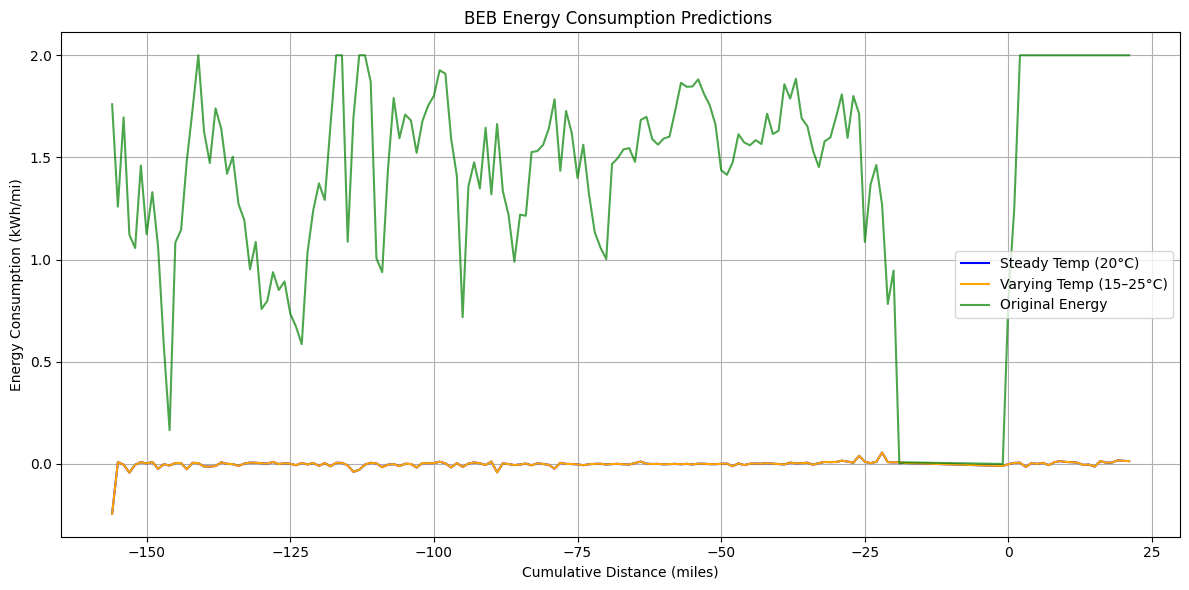

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predictions CSV 
data = pd.read_csv('BEB_predictions.csv')

# Add cumulative miles
data['cumulative_miles'] = data['miles'].cumsum()

# Group and average numeric columns
data_agg = (
    data.groupby((data['cumulative_miles'] // 1).rename('mile_bin'))
    .mean(numeric_only=True)
    .reset_index()
)

# Predict using steady and varying ambient temperatures
data_agg['pred_steady_kWh_mi'] = model.predict(
    data_agg.assign(ambient_temp=data_agg['ambient_temp'])
)
data_agg['pred_varying_kWh_mi'] = model.predict(
    data_agg.assign(ambient_temp=data_agg['ambient_temp_varying'])
)

# numeric_cols = ['gpsspeed', 'grade', 'ambient_temp', 'ambient_temp_varying']
# data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')
# data = data.dropna(subset=numeric_cols)

# data_agg['pred_steady_kWh_mi'] = data_agg['pred_steady_kWh_mi'].clip(-5, 5)
# data_agg['pred_varying_kWh_mi'] = data_agg['pred_varying_kWh_mi'].clip(-5, 5)

plt.figure(figsize=(12,6))
plt.plot(data_agg['mile_bin'], data_agg['pred_steady_kWh_mi'], color='blue', label='Steady Temp (20°C)')
plt.plot(data_agg['mile_bin'], data_agg['pred_varying_kWh_mi'], color='orange', label='Varying Temp (15–25°C)')
plt.plot(data_agg['mile_bin'], data_agg['energy_kWh_mi'], color='green', alpha=0.7, label='Original Energy')
plt.xlabel("Cumulative Distance (miles)")
plt.ylabel("Energy Consumption (kWh/mi)")
plt.title("BEB Energy Consumption Predictions ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

data = pd.read_csv("BEB_predictions.csv")

# Compute statistics
summary = {
    "Scenario": ["Steady Temperature", "Varying Temperature"],
    "Min (kWh/mi)": [
        data["pred_steady_kWh_mi"].min(),
        data["pred_varying_kWh_mi"].min()
    ],
    "Max (kWh/mi)": [
        data["pred_steady_kWh_mi"].max(),
        data["pred_varying_kWh_mi"].max()
    ],
    "Mean (kWh/mi)": [
        data["pred_steady_kWh_mi"].mean(),
        data["pred_varying_kWh_mi"].mean()
    ]
}

summary_df = pd.DataFrame(summary)
print(summary_df)

              Scenario  Min (kWh/mi)  Max (kWh/mi)  Mean (kWh/mi)
0   Steady Temperature    -38.052878     24.485731      -0.002454
1  Varying Temperature    -38.052878     24.485731      -0.002454


C:\Users\dines\AppData\Local\Temp\ipykernel_4672\2381641767.py:4: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("BEB_predictions.csv")
